# Least Squares Regression: Polynomial Curve Fitting

This tutorial is meant to be a gentle introduction to machine learning. We present a simple polynomial fitting example using a least squares solution. We use this example to introduce important machine learning concepts.

The goals of this tutorial are:
  - Explain how to develop an experiment. Split your data into development set and test set.   
  - Introduce the concepts of *overfitting*, *underfitting*, and *model generalization*.
  - Introduce the *regularization* method for reducing *overfitting*.
 

This tutorial is interactive and it corresponds to an adaptation of the example presented in chapter 1 of the book:
**Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning (Information Science and Statistics). Springer-Verlag New York, Inc., Secaucus, NJ, USA.**

## Designing your experiment

Machine learning consists of building models to explain your data. When designing your experiment, you need to split your data into a development set and a test set. The development set is split in 2 sets: a train set and validation set. The train set is used to learn the parameters of the different models you are training. The validation set is employed to select the best model among the different models you trained, therefore it has a bias and cannot be used as proof of generalization. The test set is used to see if the selected model generalizes well to unseen data. 

<img src="../Figures/train_val_test.png" alt="Drawing" style="width: 500px;"/>

## Generating synthetic data

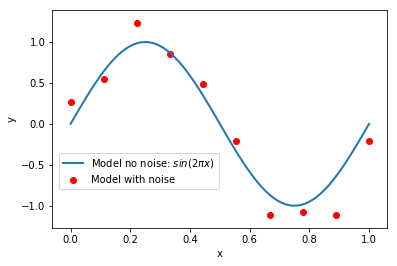

In [1]:
# Directive to make plots inline as opposed to having pop-up plots 
%matplotlib inline 
import numpy as np # Import numpy with nickname np
import matplotlib.pylab as plt # plotting library
from ipywidgets import * # Interaction library

#Noise variance
var = 0.3

#Train set
train_size = 10
x_train = np.linspace(0,1,train_size)

#signal + noise
y_train = np.sin(2*np.pi*x_train) + np.random.normal(0,var,train_size) 

#Val set
val_size = 100
x_val= np.linspace(0,1,val_size)
y = np.sin(2*np.pi*x_val)
y_val = y + np.random.normal(0,var,val_size) #signal + noise

plt.figure()
plt.plot(x_val,y,linewidth = 2.0,label = r'Model no noise: $sin(2 \pi x)$')
plt.scatter(x_train,y_train,color='red',label = "Model with noise")
plt.legend(loc = (0.02, 0.18))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Data

Observations: $$\boldsymbol{X} =(x_1,x_2,...,x_N)^T$$
Target:  $$\boldsymbol{T} =(t_1,t_2,...,t_N)^T$$


## Model

$$y(x,\boldsymbol{W})= w_0 + w_1x +w_2x^2+...+w_mx^m = \sum^M_{j=0}w_jx^j$$

## Cost Function

Quadratic cost function: $$E(\boldsymbol{W})=\frac{1}{2}\sum_{n=1}^N\{y(x_n,\boldsymbol{W})-t_n\}^2$$

Computing the derivative of the cost function and making it equal to zero, we can find the vector **W*** that minimizes the error:
$$ \boldsymbol{W}^* = (\boldsymbol{A}^T\boldsymbol{A})^{-1}\boldsymbol{A} ^T\boldsymbol{T}$$

Where **A** is defined by:

$$\boldsymbol{A} = \begin{bmatrix}
    1 & x_{1} & x_{1}^2 & \dots  & x_{1}^M \\
    1 & x_{2} & x_{2}^2 & \dots  & x_{2}^M \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{N} & x_{N}^2 & \dots  & x_{N}^M
\end{bmatrix}$$

In [2]:
#Least squares polynomial fitting solution
# Implementation of the equation shown above in the explanation
def polynomial_fit(X,T,M):
    A = np.power(X.reshape(-1,1),np.arange(0,M+1).reshape(1,-1))
    T = T.reshape(-1,1)
    W = np.dot(np.linalg.pinv(A),T)
    return W.ravel()

Plotting the least squares result varying the polynomial degree between  0 a 9. **Which model is a good model?**

In [3]:
def plotmodel(M):
    coefs = polynomial_fit(x_train, y_train, M)[::-1]
    p = np.poly1d(coefs)
    plt.figure()
    plt.plot(x_val,y,linewidth = 2.0,label = 'Real')
    plt.scatter(x_train,y_train,color='red',label= "Train")
    plt.xlabel("x")
    plt.ylabel(r'y')
    y_fit = p(x_val) 
    plt.plot(x_val,y_fit,linewidth = 2.0,label ="Estimated")
    plt.plot(x_val,y_val,'x',color='black',label = "Validation")
    plt.legend(loc=(0.02,0.02))
    plt.show()

interact(plotmodel,M=(0,9,1))  

interactive(children=(IntSlider(value=4, description=u'M', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plotmodel>

## Root mean squared error

$$E_{RMS}=\sqrt{2E(\boldsymbol{W^*})/N}$$

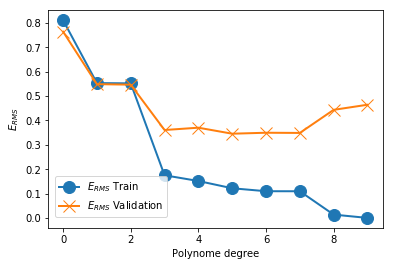

In [4]:
# Computes RMS error
def rms_error(X,T,W):
    p = np.poly1d(W)
    T_fit = p(X)
    E = np.sqrt(((T - T_fit)**2/T.size).sum())
    return E
   
m = range(10)
train = []
val = []

for M in m:
    W = polynomial_fit(x_train, y_train, M)[::-1]
    error_train = rms_error(x_train,y_train,W)
    error_val = rms_error(x_val,y_val,W)
    train.append(error_train)
    val.append(error_val)


plt.figure()
plt.plot(m,train,linewidth = 2.0,marker = 'o',markersize = 12,label = r'$E_{RMS}$ Train')
plt.plot(m,val,linewidth = 2.0,marker = 'x',markersize = 12,label = r'$E_{RMS}$ Validation')
plt.legend(loc = (0.02, 0.05))
plt.xlabel("Polynome degree")
plt.ylabel(r'$E_{RMS}$')
plt.show()

## Cost function with regularization

$$E(\boldsymbol{w})=\frac{1}{2}\sum_{n=1}^N\{y(x_n,\boldsymbol{w})-t_n\}^2 +\frac{\lambda}{2}||\boldsymbol{W}||^2$$

The solution of the above equation is given by:

$$\boldsymbol{W}^* = (\boldsymbol{A}^T\boldsymbol{A} + \lambda n\boldsymbol{I})^{-1}\boldsymbol{A} ^T\boldsymbol{T} $$

In [5]:
#Least square solution with regularization
def polynomial_fit_reg(X,T,M,lamb):
    N = X.shape[0]
    A = np.power(X.reshape(-1,1),np.arange(0,M+1).reshape(1,-1))
    lambda_matrix = lamb*N*np.eye(M+1)
    T = T.reshape(-1,1)
    aux = np.dot(A.T,A) + lambda_matrix
    aux = np.linalg.pinv(aux)
    aux2 = np.dot(A.T,T)
    W = np.dot(aux,aux2)
    return W.ravel()

In the demo below, we show the influence of $\lambda$ and $M$ in the polynomial fitting.

In [6]:
def plotmodel2(M,log_lamb):
    lamb = np.exp(log_lamb)
    coefs = polynomial_fit_reg(x_train, y_train, M,lamb)[::-1]
    print "W:",coefs
    print "Lambda", lamb
    p = np.poly1d(coefs)
    plt.figure()
    plt.plot(x_val,y,linewidth = 2.0,label = 'Real')
    plt.scatter(x_train,y_train,color='red',label= "Train")
    plt.xlabel("x")
    plt.ylabel(r'y')
    y_fit = p(x_val) 
    plt.plot(x_val,y_fit,linewidth = 2.0,label ="Estimated")
    plt.plot(x_val,y_val,'x',color='black',label = "Validation")
    plt.legend(loc=(0.02,0.02))
    plt.show()
interact(plotmodel2,M=(0,9,1),log_lamb = (-40,-9,.1))  

interactive(children=(IntSlider(value=4, description=u'M', max=9), FloatSlider(value=-25.0, description=u'log_lamb', max=-9.0, min=-40.0), Output()), _dom_classes=('widget-interact',))

<function __main__.plotmodel2>

In the demo below, we show the influence of  $\lambda$ in the fitting of a polynome of degree 9.

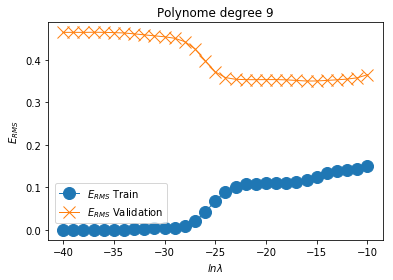

In [7]:
log_lamb = range(-40,-9)

M = 9
train = []
val = []
for l in log_lamb:
    lamb = np.exp(l)
    coeffs = polynomial_fit_reg(x_train, y_train, M,lamb)[::-1]
    error_train = rms_error(x_train,y_train,coeffs)
    error_val = rms_error(x_val,y_val,coeffs)
    train.append(error_train)
    val.append(error_val)

plt.figure()
plt.plot(log_lamb,train,linewidth = 1.0,marker = 'o',markersize = 12,label = r'$E_{RMS}$ Train')
plt.plot(log_lamb,val,linewidth = 1.0,marker = 'x',markersize = 12,label = r'$E_{RMS}$ Validation')
plt.legend(loc = (0.02, 0.075))
plt.xlabel(r'$ln\lambda$')
plt.ylabel(r'$E_{RMS}$')
plt.title("Polynome degree 9")
plt.show()

At the beginning of this tutorial we said that when designing your experiment, you split your data into train, validation (train + validation = development) and test sets. We only illustrated the train and validation sets. The train data was used to find the parameters of the polynomial fitting. The validation set was used to select the model (i.e. the degree of the polynome). Now it is necessary to test the model on unseen data. See the suggested activities below.

## Activity suggestions

- Create a test set with the same characteristics as the train and validation sets (signal shape and noise level) and test your selected model;
- Change the input signal;
- Change the noise intensity;
- Use more data for training your model;
- ...